Analyse des données

Préparation des données avec pandas


In [26]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

pd.set_option('display.float_format', lambda x: f'{x :.2f}')
from cleaner import DataCleaner
from get_dataframes import GetDataframes
import hjson

from datetime import datetime

import matplotlib.pyplot as plt
import explo_data_analysis.eda_movies as eda

with open("config.hjson") as fp:
    config = hjson.load(fp)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- On importe la dataframe "title_basics" qui contient les infos pour tout les films de la base de données.
- On enlève tout les films à caractère pornographique de notre liste.
- On nettoie les /N et les transforme en 0.
- On change les types de données des colonnes (float en int, etc...)
- On merge la dataframe "title_basics" avec "tmdb_full" pour obtenir des infos supplémentaires sur chaque film.
- On supprime les colonnes inutiles.
- On supprime les lignes pour lesquelles on a des valeurs manquantes suite au merging.
- On transforme les données dans les colonnes ayant plusieurs valeurs et les on les transforme en listes.
- On importe les dataframes "name_basics", "title_akas" et "title_principals".
- On merge la dataframe "title_akas" avec "tmdb_full".
- On filtre les films ayant eu une adaptaion en FR uniquement.
- On filtre seulement les films qui sont "Released".
- On nettoie "name_basics" comme précédement.
- On merge "name_basics", "title_principals" et on trie les acteurs, directeurs et autres dans un autre dataframe.
- On merge chaque dataframe (acteurs, directeurs, etc...) avec la liste des films qui étaient déjà merged avec tmdb.

In [27]:
datas = GetDataframes(config)
link = "movies"
df = datas.get_dataframes(
    link,
)

2023-10-31 17:07:23 INFO     TSV files already exist.
2023-10-31 17:07:23 INFO     Parquet loaded ! Importing movies...
2023-10-31 17:07:23 INFO     Dataframe movies ready to use!


- On créée une visualisation pour voir la distribution des notes moyennes de chaque film, le nombre de films par décénnie et le total de votes par décénnie.

In [28]:
eda.show_total_films_decade_plotly(df)

- On cherche quel genre de films est le plus répandu dans le dataset filtré

In [29]:
def graph_by_genre(df):
    total_genres = df.explode('titre_genres')['titre_genres'].value_counts()[::-1]
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=total_genres.values,
        y=total_genres.index,
        orientation="h",
        showlegend=False,
        marker=dict(
            color='royalblue',
            line=dict(color='black', width=1))
    ))

    fig.update_layout(
        title= "Répartition des genres de films",
        xaxis_title="Total",
        yaxis_title="Genres",
        autosize=True,
        height= 1000,
    )
    fig.show()

graph_by_genre(df)

- On peut voir que le nombre de films en dessous des années 1960 est très bas et nous décidons de ne pas les garder.
- Les films ayant moins de 5 en note moyenne ne nous intéressent pas non plus.
- Et les films ayant reçu trop peu de votes sont aussi enlevés.

In [30]:
condi =(
    (df["titre_date_sortie"] >= 1960) &
    (df["rating_avg"] >= 5) &
    (df["rating_votes"] >= 5000)
)

df = df[condi].reset_index(drop='index')

- Ici nous filtrons les genres qui n'ont que peu d'interet pour le cinéma.

In [31]:
genres_ = ["Music", "Documentary", "Reality-TV", "News"]
df = df[df['titre_genres'].apply(lambda x: all(g not in x for g in genres_))]

In [32]:
graph_by_genre(df)

- On peut désormais ré-afficher la distribution des notes moyennes, le total des films par décénnie et le nombre moyen des votes par décénnies

In [33]:
eda.show_total_films_decade_plotly(df)

- On cherche des informations sur la durée des films en minutes

In [34]:
def boxplot(df: pd.DataFrame):
    fig = px.box(
        data_frame = df,
        y = "titre_duree",
        points="outliers",
    )
    fig.update_layout(
        title="Durée des Films",
        yaxis_title="Durée des Films",
        showlegend=False
    )

    fig.show()

In [35]:
boxplot(df)

- On constate qu'il y a beaucoup trop de films avec des durées bien trop longues ainsi que des films trop courts qui devraient être considéré plutot comme des court-métrages.
- On enlève donc les films en dessous de 62 minutes et au dessus de 210 minutes (3h30)

In [36]:
condi =(
    ~((df["titre_duree"] < 62) | (df["titre_duree"] > 210))
)
df = df[condi].reset_index(drop='index')

boxplot(df)

- On cherche les 10 premiers pays desquels proviennent les films du dataset.

In [37]:
df

,titre_id,titre_str,titre_date_sortie,titre_duree,titre_genres,rating_avg,rating_votes,original_language,original_title,popularity,production_countries,revenue,spoken_languages,status,region,cuts
0,tt0035423,Kate & Leopold,2001,118,"[Comedy, Fantasy, Romance]",6.40,87747,en,Kate & Leopold,15.77,[US],76019048.00,"[en, fr, it]",Released,FR,2000-2009
1,tt0052832,The Fugitive Kind,1960,119,"[Drama, Romance]",7.10,6895,en,The Fugitive Kind,5.98,[US],0.00,[en],Released,FR,1960-1969
2,tt0052997,The League of Gentlemen,1960,116,"[Comedy, Crime, Drama]",7.20,5092,en,The League of Gentlemen,5.16,[GB],0.00,[en],Released,FR,1960-1969
3,tt0053459,Eyes Without a Face,1960,90,"[Drama, Horror]",7.60,34033,fr,Les Yeux sans visage,9.05,"[FR, IT]",58656.00,[fr],Released,FR,1960-1969
4,tt0053472,Breathless,1960,90,"[Crime, Drama]",7.70,86060,fr,À bout de souffle,13.45,[FR],0.00,"[fr, en]",Released,FR,1960-1969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11537,tt9894470,VFW,2019,92,"[Action, Crime, Horror]",6.10,9296,en,VFW,10.74,[US],0.00,"[es, en]",Released,FR,2010-2019
11538,tt9898858,Coffee & Kareem,2020,88,"[Action, Comedy, Crime]",5.20,14325,en,Coffee & Kareem,12.95,[US],0.00,[en],Released,FR,>2020
11539,tt9900782,Kaithi,2019,145,"[Action, Adventure, Crime]",8.40,38145,ta,கைதி,9.74,[IN],0.00,"[ta, te]",Released,FR,2010-2019
11540,tt9907782,The Cursed,2021,111,"[Fantasy, Horror, Mystery]",6.20,14602,en,The Cursed,22.87,[US],4588389.00,[en],Released,FR,>2020


In [ ]:
# import country_converter as coco

# def rename_country(country_name: str):
#     cc = coco.CountryConverter()
#     cc.convert(names=country_name, to='name', enforce_list=True)


# df["production_countries"] = df["production_countries"].apply(lambda x: rename_country(x))

In [38]:
def graph_by_country(df):
    """Trace un graphique Plotly pour le nombre de films par pays."""
    total = df.explode('production_countries')['production_countries'].value_counts()[:10]
    fig = go.Figure()

    fig.add_trace(go.Bar(
        y=total.index,
        x=total.values,
        orientation='h',
        marker=dict(
            color="royalblue",
            line=dict(color='black', width=1)
        )
    ))

    fig.update_layout(
        title="Nombre de films par Pays",
        xaxis_title="Nombre de films",
        yaxis_title="Pays",
        autosize=True,
        height=800
    )

    fig.update_yaxes(autorange="reversed")
    fig.show()

graph_by_country(df)

- On cherche si il y a une augmentation ou diminution de la durée des films dans le temps.

In [40]:
boxplotdf = df

boxplotdf["cuts"] = boxplotdf["cuts"].astype(str)
boxplotdf.sort_values("cuts", inplace=True)

fig = px.box(
    data_frame = boxplotdf,
    x = "cuts",
    y = "titre_duree",
    color = "cuts",
    points=False,
)
fig.update_layout(
    title="Durée des Films par Décénnie",
    xaxis_title="Décénnie",
    yaxis_title="Durée des Films",
    showlegend=False
    # legend=dict(
    #     yanchor="top",
    #     y=0.99,
    #     xanchor="left",
    #     x=0.01
    # )
)
fig.show()

In [48]:
df[((df["titre_duree"] > 170) & (df["titre_date_sortie"] > 2020))]

,titre_id,titre_str,titre_date_sortie,titre_duree,titre_genres,rating_avg,rating_votes,original_language,original_title,popularity,production_countries,revenue,spoken_languages,status,region,cuts
6941,tt11375428,Hridayam,2022,172,"[Drama, Musical, Romance]",8.10,14425,ml,ഹൃദയം,2.71,[IN],0.00,"[ml, ta]",Released,FR,>2020
7533,tt13539646,The Wandering Earth II,2022,173,"[Action, Adventure, Drama]",7.00,11530,zh,流浪地球2,78.48,[CN],604380922.00,"[zh, ja, fr, ru, en]",Released,FR,>2020
7530,tt13521006,Beau Is Afraid,2023,179,"[Comedy, Drama, Horror]",6.80,43433,en,Beau Is Afraid,61.30,"[FI, US]",5769331.00,[en],Released,FR,>2020
8158,tt1630029,Avatar: The Way of Water,2022,192,"[Action, Adventure, Fantasy]",7.60,463665,en,Avatar: The Way of Water,2857.87,[US],2319331580.00,[en],Released,FR,>2020
8565,tt1877830,The Batman,2022,176,"[Action, Crime, Drama]",7.80,737566,en,The Batman,193.57,[US],770945583.00,[en],Released,FR,>2020
11407,tt9179430,Vikram,2022,175,"[Action, Crime, Thriller]",8.30,67512,ta,விக்ரம்,8.43,[IN],54172014.00,"[ml, ta]",Released,FR,>2020
6682,tt10579952,Master,2021,179,"[Action, Crime, Thriller]",7.30,80368,ta,மாஸ்டர்,4.92,[IN],0.00,[ta],Released,FR,>2020
6696,tt10640346,Babylon,2022,189,"[Comedy, Drama, History]",7.10,148896,en,Babylon,119.47,[US],56351455.00,"[cn, en, es]",Released,FR,>2020
6763,tt10806040,Valimai,2022,178,"[Action, Crime, Thriller]",6.10,20314,ta,வலிமை,3.99,[IN],0.00,[ta],Released,FR,>2020
11450,tt9389998,Pushpa: The Rise - Part 1,2021,179,"[Action, Crime, Drama]",7.60,83087,te,పుష్పా - The Rise,24.87,[IN],0.00,[te],Released,FR,>2020


- On cherche les 10 films avec le plus de votes sans compter les documentaires, concerts et films d'animations.

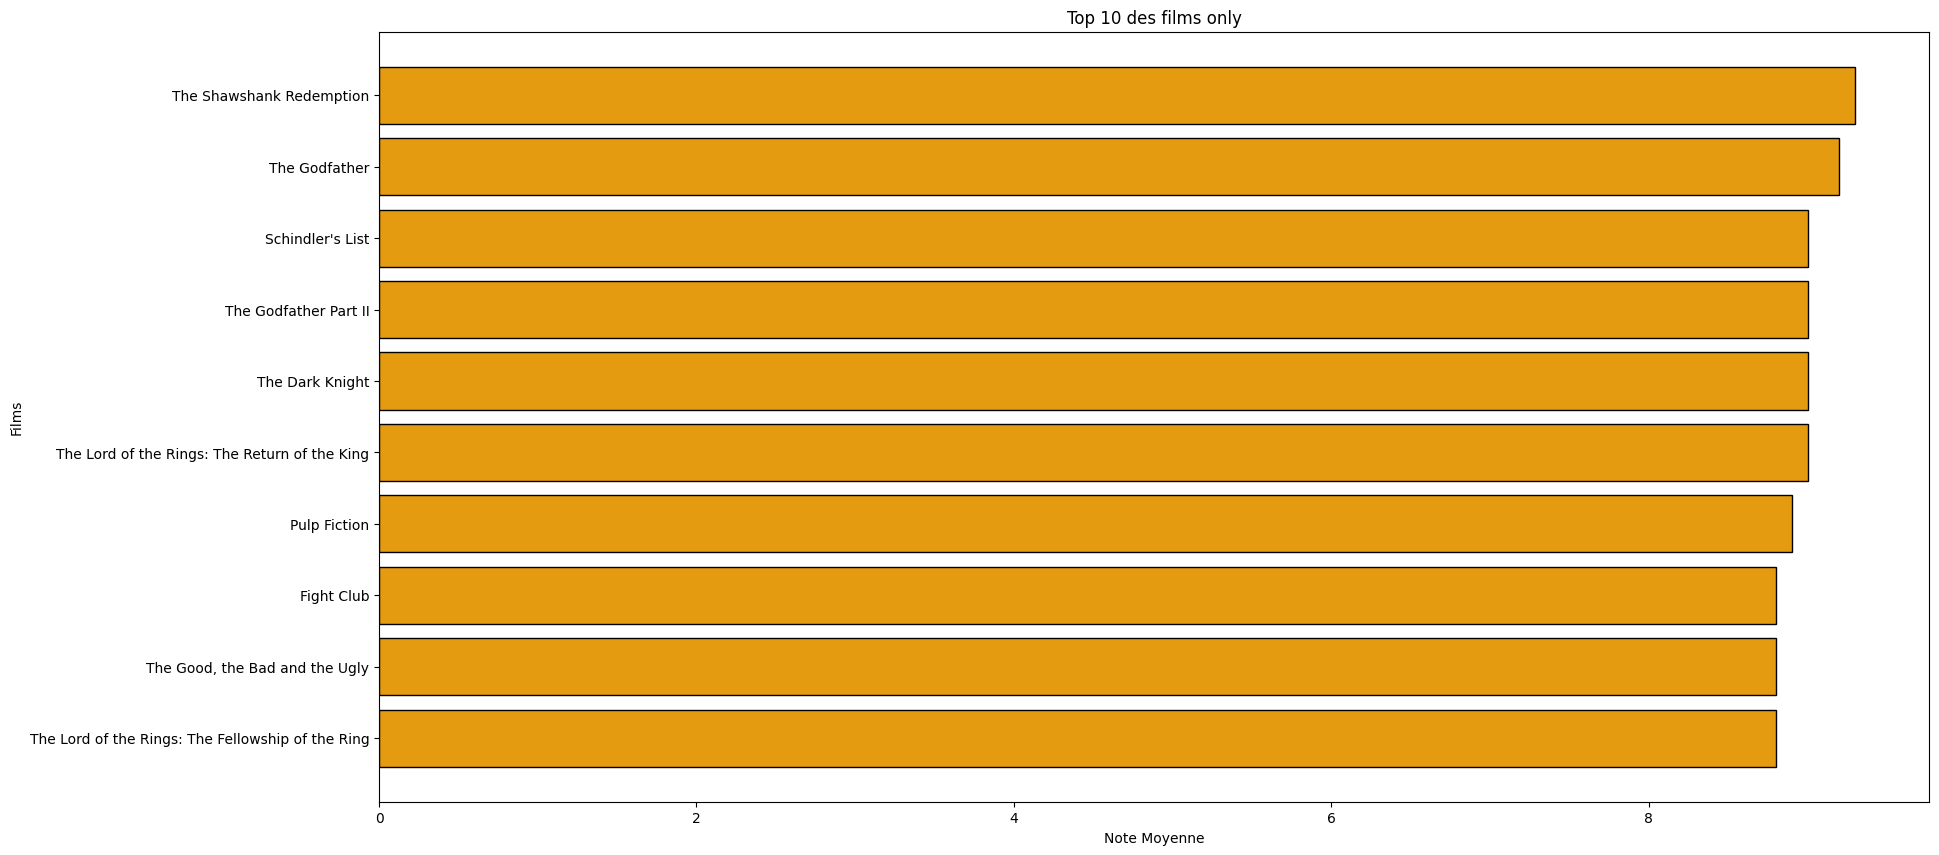

In [15]:
# Je dégage pour les films d'animation les concerts et les docs.
genres_ = ['Animation', 'Music', 'Musical', 'Documentary'] # 'Animation',
df_filtre = df[df['titre_genres'].apply(lambda x: all(g not in x for g in genres_))]
# Je veux uniquement les films ayant eu le plus de vote, je filtre par quantile 0.75 sup only.
df_filtre = df_filtre[df_filtre['rating_votes'] > df_filtre['rating_votes'].quantile(0.75)]

# Groupe les films par la moyenne ratings, ne prend que le top 10
grouped_films = (
    df_filtre.groupby('titre_str')['rating_avg']
    .mean()
    .reset_index()
    .sort_values("rating_avg", ascending=False)
    .head(10)[::-1]
)

plt.figure(figsize=(20, 10))
plt.barh(
    grouped_films['titre_str'],
    grouped_films['rating_avg'],
    color='#e49b0f',
    edgecolor = "black"
)
plt.xlabel('Note Moyenne')
plt.ylabel('Films')
plt.title('Top 10 des films only')
plt.show()


In [16]:
# #  World record of the longest documentary
# # source :https://fr.wikipedia.org/wiki/Ambianc%C3%A9
# longest = actor[actor["titre_duree"] == 43200]
# n = longest[["titre_str", "titre_duree"]].iloc[0]
# heure = n["titre_duree"] // 60
# jours = heure // 24
# print(f"Le film le plus long est {n['titre_str']} d'une durée de {heure} heures soit {jours} jours")
# # All time median for duration
# print(f"All time duration median : {round(actor['titre_duree'].median())} minutes")